# Testing divide and conquer

Summary: works well if extraction wavelength step size isn't too small.

In [1]:
from specter.extract import ex2d
import numpy as np
import desimodel.io
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
psf = desimodel.io.load_psf('r')

## Testing a noisy image with no signal

In [3]:
readnoise = 2.5
img = np.random.normal(size=(psf.npix_y, psf.npix_x), scale=readnoise)
imgivar = np.ones_like(img)/readnoise**2

In [4]:
ww = np.arange(7000, 7060, 1)
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=30)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=15)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

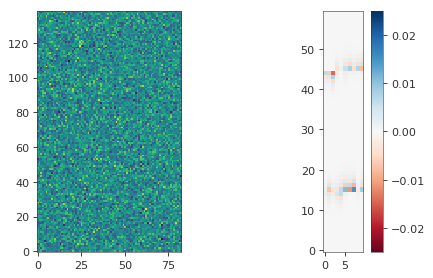

In [5]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-0.025, vmax=0.025); colorbar()

## Test noisy image with signal

In [6]:
influx = np.random.uniform(0, 1000, size=(10, len(ww)))
noiseless_img = psf.project(ww, influx)
imgvar = readnoise + noiseless_img
img = noiseless_img + np.random.normal(scale=np.sqrt(imgvar))
imgivar = 1/imgvar

In [7]:
ww = np.arange(7000, 7060, 1)
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=30)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 10, ww, wavesize=15)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

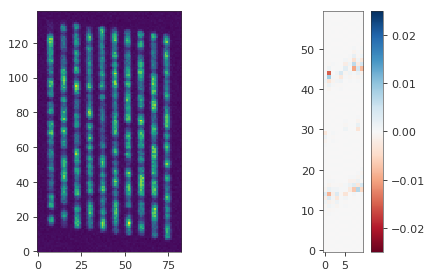

In [8]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-0.025, vmax=0.025); colorbar()

## Recreate specter.test.test_extract

Note that differences are now ${\cal O}(1\sigma)$ instead of ${\cal O}(0.01\sigma)$

In [9]:
from pkg_resources import resource_filename
import specter.psf
testpsf = specter.psf.load_psf(resource_filename("specter.test", "t/psf-spot.fits"))

In [10]:
np.random.seed(0)
nspec = 10
wmin = min(testpsf.wavelength(0, y=0), testpsf.wavelength(nspec-1, y=0))
wmin, wmax = testpsf.wavelength(0, y=(10,90))
ww = np.arange(wmin, wmax, 0.5)
nwave = len(ww)

phot_shape = (nspec, nwave)
phot = np.random.uniform(1, 1000, size=phot_shape)
image_orig = testpsf.project(ww, phot, verbose=False)
var = 1.0 + image_orig
img = image_orig + np.random.normal(scale=np.sqrt(var))
imgivar = 1/var

In [11]:
flux1, ivar1, Rdata1 = ex2d(img, imgivar, testpsf, 0, nspec, ww, wavesize=len(ww)//5, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, testpsf, 0, nspec, ww, wavesize=len(ww)//2, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

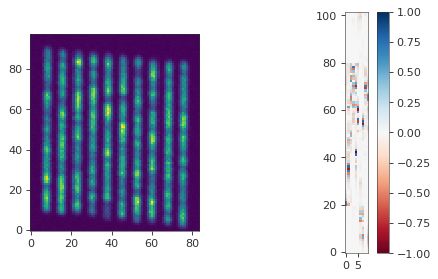

In [12]:
xmin, xmax, ymin, ymax = testpsf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-1, vmax=1); colorbar()

## Adapt original example to be more like test
Still has large deviations

In [13]:
np.random.seed(0)
wmin, wmax = psf.wavelength(0, y=(10,90))
ww = np.arange(wmin, wmax, 0.5)
nwave = len(ww)

phot_shape = (nspec, nwave)
phot = np.random.uniform(1, 1000, size=phot_shape)
image_orig = psf.project(ww, phot, verbose=False)
var = 1.0 + image_orig
img = image_orig + np.random.normal(scale=np.sqrt(var))
imgivar = 1/var

In [14]:
flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//5, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//2, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

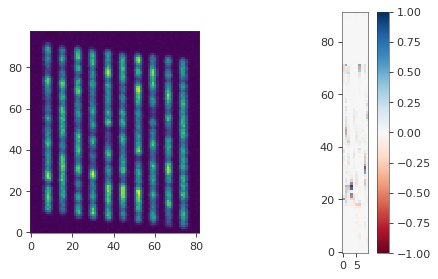

In [15]:
xmin, xmax, ymin, ymax = psf.xyrange([0,10], ww)
subplot(121)
imshow(img[ymin:ymax, xmin:xmax])
subplot(122)
imshow(((flux1-flux2)/fluxerr).T, cmap='RdBu', vmin=-1, vmax=1); colorbar()

## Difference is extraction step size

In [16]:
wmin = psf.wavelength(0, y=10)
wmax = wmin + 60
wsteps = (0.5, 0.6, 0.7, 0.8, 0.9, 1.0)
maxdiff = list()
for wstep in wsteps:
    ww = np.arange(wmin, wmax, wstep)
    nwave = len(ww)
    phot_shape = (nspec, nwave)
    phot = np.random.uniform(1, 1000, size=phot_shape)
    image_orig = psf.project(ww, phot, verbose=False)
    var = 1.0 + image_orig
    img = image_orig + np.random.normal(scale=np.sqrt(var))
    imgivar = 1/var

    flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//5)
    flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, nspec, ww, wavesize=len(ww)//2)
    fluxerr = np.sqrt(1/ivar1 + 1/ivar2)
    
    maxdiff.append(np.max(np.abs((flux1-flux2)/fluxerr)))

(0, 1)

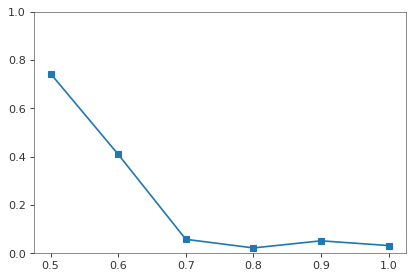

In [17]:
plot(wsteps, maxdiff, 's-')
ylim(0, 1)

In [18]:
maxdiff

[0.74353919745465424,
 0.40916469153960894,
 0.057594007594515689,
 0.021896327891030548,
 0.051340086472699553,
 0.031739446035328897]

# Timing tests for subbundle extraction

In [19]:
#- Make sure we have right PSF
psf = desimodel.io.load_psf('r')
ww = np.arange(7000, 7200, 1)

In [20]:
readnoise = 2.5
img = np.random.normal(size=(psf.npix_y, psf.npix_x), scale=readnoise)
imgivar = np.ones_like(img)/readnoise**2

In [21]:
extime = list()
nsubbundles = (1,2,3,4,5)
for n in nsubbundles:
    t0 = time.time()
    flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 25, ww, nsubbundles=n)
    dt = time.time() - t0
    extime.append(dt)
    print('{:2d} {:.1f}'.format(n, dt))

 1 25.6
 2 13.2
 3 10.7
 4 10.4
 5 10.2


In [22]:
exrate = 25*len(ww)/np.array(extime)

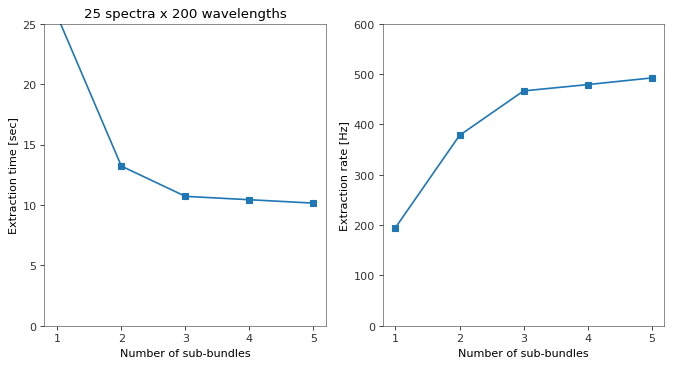

In [23]:
figure(figsize=(10,5))
subplot(121)
plot(nsubbundles, extime, 's-')
ylim(0, 25)
ylabel('Extraction time [sec]')
xticks(nsubbundles, nsubbundles)
xlabel('Number of sub-bundles')
title('25 spectra x 200 wavelengths')

subplot(122)
plot(nsubbundles, exrate, 's-')
ylim(0, 600)
ylabel('Extraction rate [Hz]')
xticks(nsubbundles, nsubbundles)
xlabel('Number of sub-bundles')
savefig('subbundle-speed.png')

In [24]:
np.max(exrate) / np.min(exrate)

2.5251462652578143

In [ ]:
exrate / exrate[0]

array([ 1.        ,  1.9397157 ,  2.39304556,  2.45740015,  2.52514627])

## More examples

In [ ]:
ww = np.arange(7000, 7090, 1)
readnoise = 2.5
influx = np.random.uniform(0, 100, size=(25, len(ww)))
noiseless_img = psf.project(ww, influx)
imgvar = readnoise + noiseless_img
img = noiseless_img + np.random.normal(scale=np.sqrt(imgvar))
imgivar = 1/imgvar

flux1, ivar1, Rdata1 = ex2d(img, imgivar, psf, 0, 25, ww, wavesize=60, nsubbundles=1)
flux2, ivar2, Rdata2 = ex2d(img, imgivar, psf, 0, 25, ww, wavesize=30, nsubbundles=2)
fluxerr = np.sqrt(1/ivar1 + 1/ivar2)

In [ ]:
xmin, xmax, ymin, ymax = psf.xyrange([0,25], ww)

subplot(121)
imshow(img[ymin:ymax, xmin:xmax], vmin=0, vmax=20, cmap='viridis')
title('image')
xlabel('CCD X')
ylabel('CCD Y')

subplot(122)
imshow(((flux1-flux2)/fluxerr).T, vmin=-0.025, vmax=0.025, cmap='RdBu',
    extent=(0,24, ww[0], ww[-1]))
title('noise-weighted flux difference')
xlabel('fiber #')
ylabel('wavelength')
colorbar()
savefig('divide-and-conquer-residuals.png')